${\bf Task\ } ({\bf\ sound\ speed})$

#### Import the libraries we are going to use

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Set the coordinates

In [2]:
def coordinates(n, Lbox=2.0*np.pi):
    ds=Lbox/n
    # Two ways of accomplishing the same thing, either with arange or linspace
    # x = np.linspace(0., Lbox, num=n, endpoint=False)+0.5*ds
    x = ds*(np.arange(n) + 0.5)
    return ds,x

#### Slopes, derivatives and other functions

In [3]:
def left_slope(f,axis=0):
    return (f-np.roll(f,1,axis))

def no_slope(f):
    return np.zeros_like(f)

# Centered derivative; e.g. no slope limiter. This is unstable!
def Cen(f):
    ls = left_slope(f) # left slope
    rs=np.roll(ls,-1)  # roll down once (giving the slope to the right)
    return 0.5*(ls+rs) # the average of the left and right slopes is simply the centered derivative (deriv(f))

# MinMod slope limiter
def MinMod(f):
    ls = left_slope(f)                      # left slope
    rs = np.roll(ls,-1)                     # right slope
    sign = np.ones(ls.shape)                # start with making sign equal +1
    sign[np.where(ls < 0.0)] -= 1.0         # where left slope is negative, make sign 0
    sign[np.where(rs < 0.0)] -= 1.0         # if left *and* right slope are negative, sign is -1, if only right slope is negative, sign is 0
    return np.minimum(abs(ls),abs(rs))*sign # return the smallest size of the two slopes with correct sign, but zero if they disagree about sign

# MonCen slope limiter
def MonCen(f):
    ls = left_slope(f)                      # left slope
    rs = np.roll(ls,-1)                     # right slope
    cs = np.zeros_like(ls)                  # MonCen starts out as zero slope
    w  = np.where(ls*rs>0.0)                # Where both slopes agree in sign, we compute it
    cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])     # MonCen slope is the harmonic average of the left and right state
    return cs

def wide_fig(title='',s=''):
    if title=='':
        title='{}  Courant={:.2f}'.format(s,C)
    plt.figure(figsize=(14,4))
    plt.title(title);

#### Define the class for creating a hydro scheme

In [4]:
# Define an hydro state including all auxiliary scalars and coordinates in a class
class hd():
    def __init__(self,n,gamma,cs=1.,Lbox=2.0*np.pi):
        dx, x = coordinates(n, Lbox=Lbox)
        self.n = n                             # number of points
        self.dx = dx                           # cell size
        self.Lbox = Lbox                       # Box size
        self.x = x                             # coordinate axis
        self.gamma = gamma                     # adiabatic index
        self.cs = cs                           # initial sound speed, if isothermal it is fixed
        self.t = 0.                            # time
        self.rho = np.ones(n)                  # density  
        self.Px  = np.zeros(n)                 # momentum density = rho*velocity_x
        if gamma != 1.0:                       # non-isothermal
            Pressure = cs**2*self.rho / gamma
            Eint = Pressure / (self.gamma - 1.)
            self.Etot = Eint   # total energy

    # Compute velocity from state vector
    def velocity(self):
        """ Compute velocity from conservative variables """
        return self.Px / self.rho

    # Compute pressure from state vector
    def pressure(self):
        """ Compute pressure from conservative variables """
        if self.gamma==1.0:
            P = self.cs**2 * self.rho
        else:
            Eint = self.Etot - 0.5 * self.Px**2 / self.rho # Internal energy
            P = (self.gamma-1.)*Eint
        return P

    # compute sound speed
    def sound_speed(self):
        """ Sound speed for HD """
        # if gamma=1 gas is isothermal, and sound speed is a property of the equation of state
        if (self.gamma==1.):
            return self.cs
        else:
            P = self.pressure()
            cs = np.sqrt(self.gamma*P/self.rho)
            return cs

    # Courant condition with default Courant number=0.2 for a fluid
    # maximum propagation velocity is max(|v| + sound speed), where max is taken over all cells
    def Courant(self,Cdt=0.2):
        """ Courant condition for HD """
        speed = abs(self.velocity())
        dt = Cdt * self.dx / np.max(speed + self.sound_speed())
        return dt

#### Usefull class, functions for the MUSCL scheme and the MUSCL function

In [5]:
class void():
    """ Empty class, used to create ad hoc objects """
    pass

# Conservative variables computed from primitve variable
def primitive_to_conservative(q):
    U = void()
    U.D  = q.D
    U.mU = q.D*q.U
    if gamma!=1:
        Eint=q.P/(q.gamma-1)
        U.Etot=Eint+0.5*(q.D*q.U*q.U)
    return U

# Hydro flux from conservative and primitive variables
def Hydro_Flux(q,U):
    F = void()
    F.D  = U.mU
    F.mU = U.mU * q.U + q.P
    if gamma!=1:
        F.Etot=(U.Etot+q.P)*q.U
    return F

def HLL(ql,qr):
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P / ql.D)**0.5
    c_right = (qr.gamma*qr.P / qr.D)**0.5
    c_max = np.maximum(c_left,c_right)
    
    # maximum wave speeds to the left and right (guaranteed to have right sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # HLL flux based on wavespeeds. If SL < 0 and SR > 0 then mix state appropriately
    # The general form is
    #    (SR * F_left - SL * F_right + SL * SR *(U_right - U_left)) / (SR - SL)
    # where U is the state vector of the conserved variables
    Flux = void()
    Flux.D  = (SR*Fl.D  - SL*Fr.D  + SL*SR*(Ur.D  - Ul.D )) / (SR - SL)
    Flux.mU = (SR*Fl.mU - SL*Fr.mU + SL*SR*(Ur.mU - Ul.mU)) / (SR - SL)
    if gamma!=1:
        Flux.Etot = (SR*Fl.Etot - SL*Fr.Etot + SL*SR*(Ur.Etot - Ul.Etot)) / (SR - SL)

    return Flux

# Hydrodynamics solver based on MUSCL scheme
def muscl(u,dt,Slope=MinMod,Riemann_Solver=HLL):
    dx = u.dx
    idx = 1. / u.dx
    dtdx = dt / u.dx

    # 1) Compute primitive variables at cell center (rho, v, P)
    rho = u.rho
    v   = u.velocity()
    P   = u.pressure()

    # 2) Compute slope limited derivatives based on centered points
    drhodx = Slope(rho) * idx
    dvdx   = Slope(v) * idx
    dPdx   = Slope(P) * idx

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    # Time evolution for source terms
    rho_t = - v * drhodx - dvdx * rho
    v_t   = - v * dvdx - dPdx / rho
    P_t   = - v * dPdx - u.gamma*P*dvdx
    
    # Spatial interpolation + time terms
    # left state at t + dt/2 -- AS SEEN FROM THE INTERFACE
    ql = void()
    ql.gamma = u.gamma
    ql.D = rho + 0.5 * (dt*rho_t + dx*drhodx)
    ql.U = v   + 0.5 * (dt*v_t   + dx*dvdx)
    if u.gamma==1:
        ql.P = u.cs**2 * ql.D
    else:
        ql.P = P + 0.5 * (dt*P_t + dx*dPdx)
    
    # Spatial interpolation + time terms
    # right state at t + dt/2 -- AS SEEN FROM THE INTERFACE
    qr = void()
    qr.gamma = u.gamma
    qr.D = rho + 0.5 * (dt*rho_t - dx*drhodx)
    qr.U = v   + 0.5 * (dt*v_t   - dx*dvdx)
    if u.gamma==1:
        qr.P = u.cs**2 * qr.D
    else:
        qr.P = P + 0.5 * (dt*P_t - dx*dPdx)

    # make sure that right state is centered correctly.
    # Numerical index follow upstaggered interfaces,
    qr.D = np.roll(qr.D,-1)
    qr.U = np.roll(qr.U,-1)
    qr.P = np.roll(qr.P,-1)

    # 4) Solve for flux based on interface values
    Flux = Riemann_Solver(ql,qr)
    
    # 5) Update conserved variables.
    #    From the cell center (at x_i) point of view:
    #       * 1st term is the upstaggered value at the interface position x_i + dx/2
    #       * 2nd term is the downstaggered value at the interface position x_i - dx/2. Therefore we roll.
    u.rho += - dtdx * (Flux.D  - np.roll(Flux.D,1))
    u.Px  += - dtdx * (Flux.mU - np.roll(Flux.mU,1))
    if gamma!=1:
        u.Etot  += - dtdx * (Flux.Etot - np.roll(Flux.Etot,1))
    
    return u

#### Set the initial conditions and the form of the wave

In [6]:
def wave(x,v,t):
    f=np.sin(x-v*t)
    return f

def initial_condition(u,eps,rho0=1.):
        velocity = eps*u.sound_speed()*wave(u.x,0.,0.)     # velocity
        u.rho = rho0*(1. + eps*wave(u.x,0.,0.)) # density for a sound wave with relative amplitude "eps"
        u.Px = rho0*velocity                    # momentum density
        # check if not an isothermal setup, and then compute the total energy
        if u.gamma != 1.:
            P = u.cs**2 * u.rho / u.gamma
            Eint = P / (u.gamma - 1.)
            u.Etot = Eint + 0.5 * u.Px**2 / u.rho

#### The main problem

Number of iterations : 324
Time                 : 6.283185307179586
Resolution           : 64
Periods advected     : 1.0


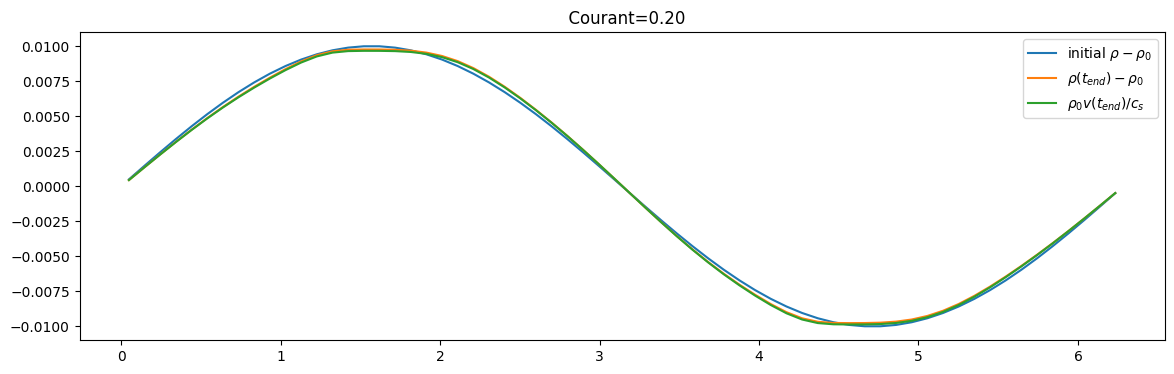

In [7]:
n = 64        # number of grid points
C = 0.2        # Courant number (<0.5 for stability)
rho0 = 1.      # Average density
gamma = 1     # Adiabatic index
cs  = 1.       # Sound speed
eps = 0.01     # relative amplitude of soundwave
Slope=MonCen   # choose a slope
Riemann_Solver=HLL # choose a Riemann solver

# set up exepriment with a soundwave initial condition
u = hd(n,gamma,cs=cs)
initial_condition(u,eps=eps,rho0=rho0)

periods = 1.0  # number of periods to advect
tend = periods*u.Lbox / u.cs # corresponding end time if wave moves with sound speed (cs)

# caluclate an approximate guess for the
# number of iterations needed
# dt ~ C * dx / cs, since cs is the soundspeed
# 1.5 is a safety factor, given that the phase
# velocity of the wave may limit the time step a bit
nt = int(1.5 * tend / (C * u.dx / cs))

wide_fig()
plt.plot(u.x,u.rho - rho0,'-',label=r'initial $\rho-\rho_0$')

it = 0
while(u.t < tend and it < nt):
    dt=u.Courant(C) # get size of dt
    if (u.t+dt > tend): # make sure we arrive at tend exactly
        dt = tend - u.t

    u = muscl(u,dt,Slope=Slope,Riemann_Solver=Riemann_Solver) # Evolve solution by dt
    # increment time and iteration count
    u.t += dt 
    it += 1

# Plot the final density in orange
plt.plot(u.x,u.rho-rho0,'-',label=r'$\rho(t_{end}) - \rho_0$')

# Plot the corresponding velocity. Rescale with a factor of rho0 / u["cs"] to make
# it same amplitude as density (can be seen by e.g. dimensional analysis)
plt.plot(u.x,rho0*u.velocity()/u.cs,'-',label=r'$\rho_0 v(t_{end}) / c_s$')


plt.legend();

print("Number of iterations :", it)
print("Time                 :", u.t)
print("Resolution           :", u.n)
print("Periods advected     :", periods)
if (u.t < tend):
    print("OBS hit maximum number of iterations, something may be broken.")
    print("nt   =", nt)
    print("t    =", u.t)
    print("tend =", tend)

Text(0.5, 0, 'x')

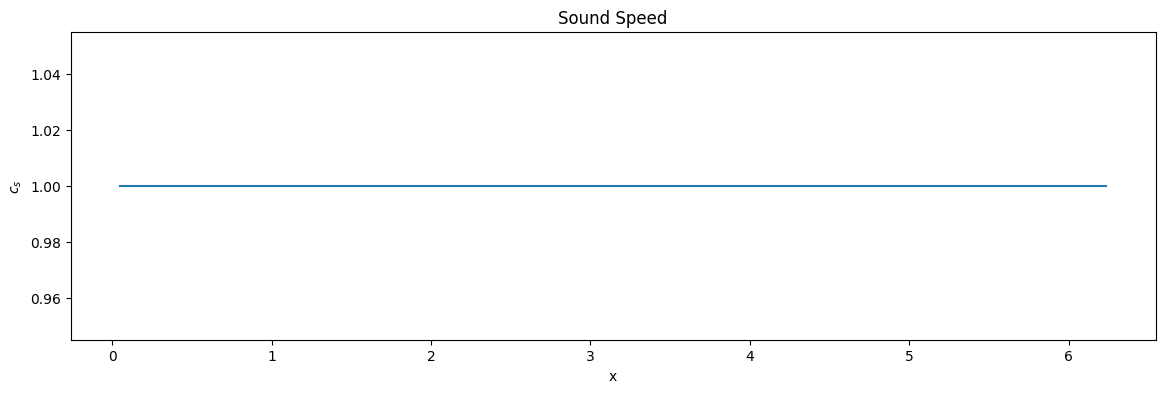

In [8]:
wide_fig()
plt.plot(u.x,np.sqrt(u.pressure()/u.rho))
plt.title('Sound Speed')
plt.ylabel('$c_{s}$')
plt.xlabel('x')

At this problem, we have defined that the value of the sound speed is equal to one. We are expecting that since have assumed an isothermal problem ($\gamma=1$), the value of the sound speed, would be stable. The stability of its value it is proven through the above plots. 

$\bf Considering\ the\ energy$

Number of iterations : 324
Time                 : 6.283185307179586
Resolution           : 64
Periods advected     : 1.0


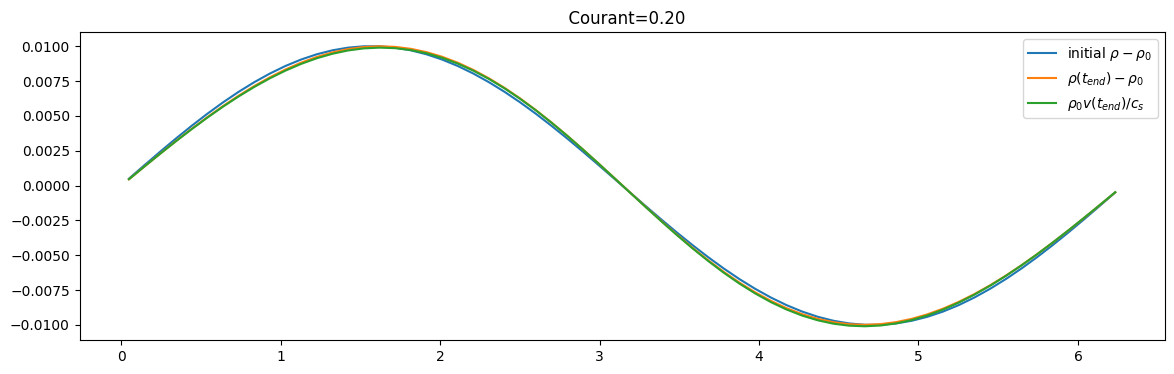

In [9]:
n = 64        # number of grid points
C = 0.2        # Courant number (<0.5 for stability)
rho0 = 1.      # Average density
gamma = 1.4     # Adiabatic index
cs  = 1.       # Sound speed
eps = 0.01     # relative amplitude of soundwave
Slope=Cen   # choose a slope
Riemann_Solver=HLL # choose a Riemann solver

# set up exepriment with a soundwave initial condition
u = hd(n,gamma,cs=cs)
initial_condition(u,eps=eps,rho0=rho0)

periods = 1.0  # number of periods to advect
tend = periods*u.Lbox / u.cs # corresponding end time if wave moves with sound speed (cs)

# caluclate an approximate guess for the
# number of iterations needed
# dt ~ C * dx / cs, since cs is the soundspeed
# 1.5 is a safety factor, given that the phase
# velocity of the wave may limit the time step a bit
nt = int(1.5 * tend / (C * u.dx / cs))

wide_fig()
plt.plot(u.x,u.rho - rho0,'-',label=r'initial $\rho-\rho_0$')

it = 0
while(u.t < tend and it < nt):
    dt=u.Courant(C) # get size of dt
    if (u.t+dt > tend): # make sure we arrive at tend exactly
        dt = tend - u.t

    u = muscl(u,dt,Slope=Slope,Riemann_Solver=Riemann_Solver) # Evolve solution by dt
    # increment time and iteration count
    u.t += dt 
    it += 1

# Plot the final density in orange
plt.plot(u.x,u.rho-rho0,'-',label=r'$\rho(t_{end}) - \rho_0$')

# Plot the corresponding velocity. Rescale with a factor of rho0 / u["cs"] to make
# it same amplitude as density (can be seen by e.g. dimensional analysis)
plt.plot(u.x,rho0*u.velocity()/u.cs,'-',label=r'$\rho_0 v(t_{end}) / c_s$')


plt.legend();

print("Number of iterations :", it)
print("Time                 :", u.t)
print("Resolution           :", u.n)
print("Periods advected     :", periods)
if (u.t < tend):
    print("OBS hit maximum number of iterations, something may be broken.")
    print("nt   =", nt)
    print("t    =", u.t)
    print("tend =", tend)

Text(0.5, 0, 'x')

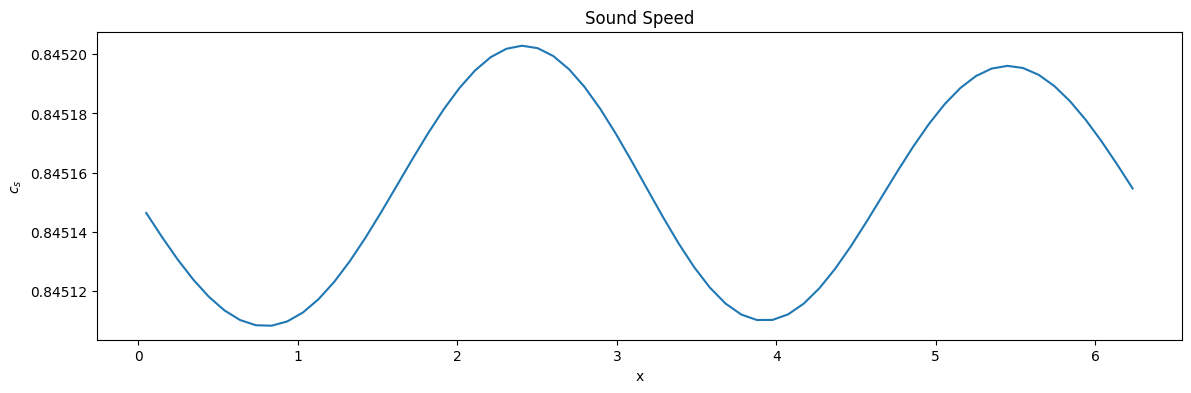

In [10]:
wide_fig()
plt.plot(u.x,np.sqrt(u.pressure()/u.rho))
plt.title('Sound Speed')
plt.ylabel('$c_{s}$')
plt.xlabel('x')

Now, in this case we took into account the concept of energy. In order to do so, we examined the case of a non-isothermal fluid, by simple choosing a different value for $\gamma$. Particularly, we selected $\gamma=1.4$. It is obvious that the sound speed has been decreased in comparison to the initial value. Also, it shows a small volatility. The main reason is due to its dependence on the pressure. Particularly, we could recall that $c^{2}_{s}=\gamma \frac{P}{\rho}$, while the pressure is correlated to the internal energy density $\rho\epsilon$, which in turn, is related to the total energy of the system. So, we are expecting a non stable sound speed.

$\bf Amplitude\ change$

Number of iterations : 448
Time                 : 6.283185307179586
Resolution           : 64
Periods advected     : 1.0


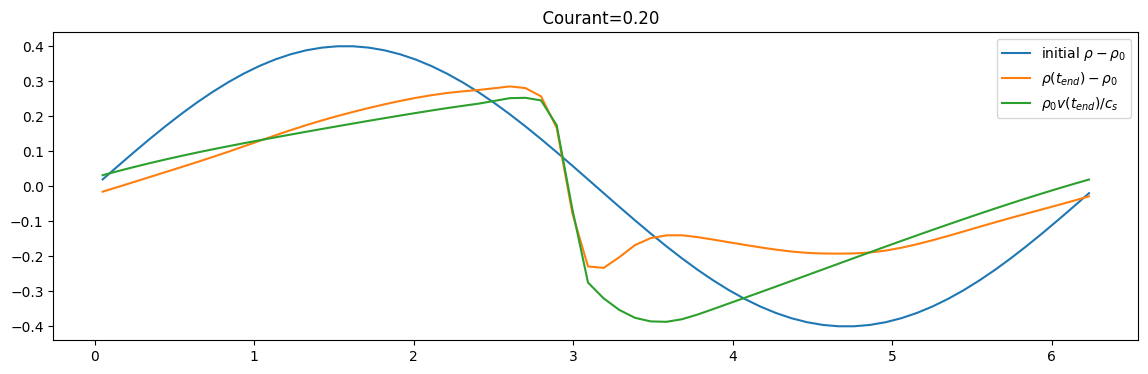

In [11]:
n = 64        # number of grid points
C = 0.2        # Courant number (<0.5 for stability)
rho0 = 1.      # Average density
gamma = 1.4     # Adiabatic index
cs  = 1.       # Sound speed
eps = 0.4     # relative amplitude of soundwave
Slope=MonCen   # choose a slope
Riemann_Solver=HLL # choose a Riemann solver

# set up exepriment with a soundwave initial condition
u = hd(n,gamma,cs=cs)
initial_condition(u,eps=eps,rho0=rho0)

periods = 1.0  # number of periods to advect
tend = periods*u.Lbox / u.cs # corresponding end time if wave moves with sound speed (cs)

# caluclate an approximate guess for the
# number of iterations needed
# dt ~ C * dx / cs, since cs is the soundspeed
# 1.5 is a safety factor, given that the phase
# velocity of the wave may limit the time step a bit
nt = int(1.5 * tend / (C * u.dx / cs))

wide_fig()
plt.plot(u.x,u.rho - rho0,'-',label=r'initial $\rho-\rho_0$')

it = 0
while(u.t < tend and it < nt):
    dt=u.Courant(C) # get size of dt
    if (u.t+dt > tend): # make sure we arrive at tend exactly
        dt = tend - u.t

    u = muscl(u,dt,Slope=Slope,Riemann_Solver=Riemann_Solver) # Evolve solution by dt
    # increment time and iteration count
    u.t += dt 
    it += 1

# Plot the final density in orange
plt.plot(u.x,u.rho-rho0,'-',label=r'$\rho(t_{end}) - \rho_0$')

# Plot the corresponding velocity. Rescale with a factor of rho0 / u["cs"] to make
# it same amplitude as density (can be seen by e.g. dimensional analysis)
plt.plot(u.x,rho0*u.velocity()/u.cs,'-',label=r'$\rho_0 v(t_{end}) / c_s$')


plt.legend();

print("Number of iterations :", it)
print("Time                 :", u.t)
print("Resolution           :", u.n)
print("Periods advected     :", periods)
if (u.t < tend):
    print("OBS hit maximum number of iterations, something may be broken.")
    print("nt   =", nt)
    print("t    =", u.t)
    print("tend =", tend)

Text(0.5, 0, 'x')

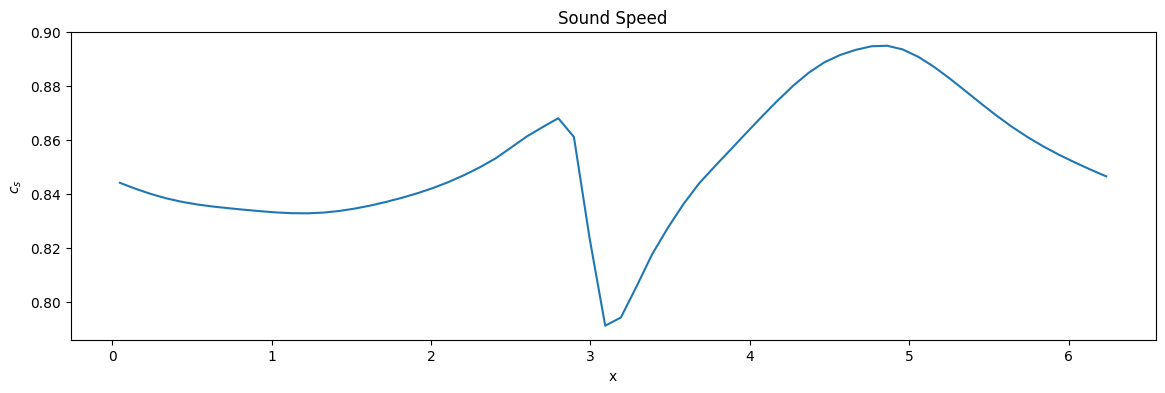

In [12]:
wide_fig()
plt.plot(u.x,np.sqrt(u.pressure()/u.rho))
plt.title('Sound Speed')
plt.ylabel('$c_{s}$')
plt.xlabel('x')

Finally, the last part of the examination is considerating a change to the amplitude of thw wave. Thus, we tried to set the amplitude value 4 times bigger than the initial one e.g $eps=0.4$. This change is affecting the density ($def\ initial\_condition$), as well as the the sound speed due to its relation with the density. As we make the amplitude bigger, the volatility of the aforementioned quantities is intense. Moreover, there is a tendency towards creating a discontiniounity. 